##Wind Analysis

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from salishsea_tools import geo_tools, viz_tools, tidetools

%matplotlib inline

### Load Data
Load wind from ERDDAP

In [7]:
# Timerange
timerange = ['2016 Jan 1 00:00', '2016 Dec 31 23:00']
timeslice = slice(timerange[0], timerange[1])

# Load Wind
wind = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
u_wind = wind.sel(time=timeslice).u_wind.values.reshape(-1, ngrid_GEM)
v_wind = wind.sel(time=timeslice).v_wind.values.reshape(-1, ngrid_GEM)
u_wind_trim = np.zeros((u_wind.shape[0], ngrid_GEM_water))
v_wind_trim = np.zeros((v_wind.shape[0], ngrid_GEM_water))
for tindex, timerows in enumerate(zip(u_wind, v_wind)):
    u_wind_trim[tindex, :] = timerows[0][mask_GEM]
    v_wind_trim[tindex, :] = timerows[1][mask_GEM]
GEM = {
    'u_wind': u_wind_trim,
    'v_wind': v_wind_trim
}

Build NEMO coords

In [4]:
# Get mask and grid files
mask = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

# Mask
tmask = mask.tmask.isel(t=0).values.astype(bool)
tmask[:, 750:, :] = 0
tmask[:, :350, :] = 0
tmask[:, :, :100] = 0

# Grid and depth
gridX, gridY = np.meshgrid(mask.x, mask.y)

# Full Grid
tmask_full = tmask[0, :, :]
ngrid = tmask_full.shape[0] * tmask_full.shape[1]
tmask_full = tmask_full.reshape(ngrid)
ngrid_water = tmask_full.sum()
gridX_full = gridX.reshape(ngrid)[tmask_full]
gridY_full = gridY.reshape(ngrid)[tmask_full]

# Sub Grid Surface
tmask_sub_0 = tmask[0, ::5, ::5]
nsubgrid = tmask_sub_0.shape[0] * tmask_sub_0.shape[1]
tmask_sub_0 = tmask_sub_0.reshape(nsubgrid)
nsubgrid_water_0 = tmask_sub_0.sum()
gridX_sub_0 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_0]
gridY_sub_0 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_0]

# Sub Grid 10 m
tmask_sub_10 = tmask[10, ::5, ::5].reshape(nsubgrid)
nsubgrid_water_10 = tmask_sub_10.sum()
gridX_sub_10 = gridX[::5, ::5].reshape(nsubgrid)[tmask_sub_10]
gridY_sub_10 = gridY[::5, ::5].reshape(nsubgrid)[tmask_sub_10]

# Depth
deptht = mask.gdept_0.isel(t=0).values
deptht = deptht.reshape(-1, ngrid)[:, tmask_full]
dz = np.diff(deptht, axis=0)

Build wind mask

In [5]:
# Open NetCDF Files
grid_NEMO = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
grid_GEM  = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

# Preallocate
ngrid_GEM = grid_GEM.gridX.shape[0] * grid_GEM.gridY.shape[0]
mask_GEM = np.zeros(ngrid_GEM, dtype=int)

# Evaluate each point on GEM grid
for index, coords in enumerate(zip(
    grid_GEM.longitude.values.reshape(ngrid_GEM) - 360,
    grid_GEM.latitude.values.reshape(ngrid_GEM))):
    
    j, i = geo_tools.find_closest_model_point(coords[0], coords[1], grid_NEMO.nav_lon, grid_NEMO.nav_lat)
    if j is np.nan or i is np.nan:
        mask_GEM[index] = 0
    else:
        mask_GEM[index] = mask.tmask.isel(z=0, x=i, y=j).values

# Reshape
mask_GEM = mask_GEM.reshape(grid_GEM.longitude.shape)

# Mask out PS and JdF
mask_GEM[200:, :] = 0
mask_GEM[:110, :] = 0
mask_GEM[:140, :125] = 0

# Reshape
mask_GEM = mask_GEM.reshape(ngrid_GEM)

# Number of water points
ngrid_GEM_water = mask_GEM.sum()

# Convert to bool
mask_GEM = mask_GEM.astype(bool)

# GEM coordinates
X, Y = np.meshgrid(grid_GEM.gridX, grid_GEM.gridY)
X_full = X.reshape(ngrid_GEM)[mask_GEM]
Y_full = Y.reshape(ngrid_GEM)[mask_GEM]

Load NEMO 2016 results from pre-prepped matfile

In [8]:
# Load NEMO np.arrays from matfile
PCAdata = loadmat('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/PCAdata.mat')

###Analysis
Filter Tides

In [9]:
# Filter tides
PCAdata['u0_filter'] = tidetools.filter_timeseries(PCAdata['u0'], method='doodson')
PCAdata['v0_filter'] = tidetools.filter_timeseries(PCAdata['v0'], method='doodson')
GEM['u_wind_filter'] = tidetools.filter_timeseries(GEM['u_wind'], method='doodson')
GEM['v_wind_filter'] = tidetools.filter_timeseries(GEM['v_wind'], method='doodson')

Build Wind Indices

In [10]:
# Build wind indices
GEM['u_wind_rotated'], GEM['v_wind_rotated'] = viz_tools.rotate_vel(GEM['u_wind'], GEM['v_wind'], origin='map')
GEM['u_wind_filter_rotated'], GEM['v_wind_filter_rotated'] = viz_tools.rotate_vel(GEM['u_wind_filter'], GEM['v_wind_filter'], origin='map')
wind_index = GEM['v_wind_rotated'].mean(axis=1)
wind_index_filter = GEM['v_wind_filter_rotated'].mean(axis=1)

Hourly meridional wind averaged over SOG and averaged surface currents over positive and negative wind index

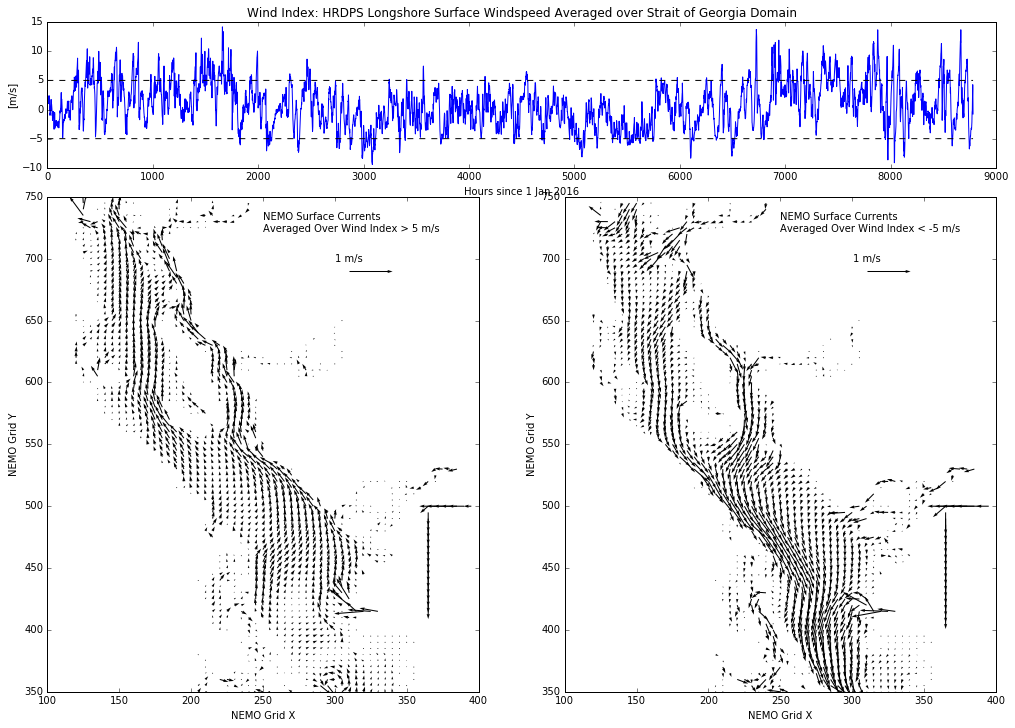

In [83]:
ax = [0, 0, 0]

fig = plt.figure(figsize=(17, 12))

gs = gridspec.GridSpec(4, 2)

ax[0] = plt.subplot(gs[0, :])
ax[1] = plt.subplot(gs[1:, 0])
ax[2] = plt.subplot(gs[1:, 1])

ax[0].plot(wind_index)
ax[0].plot(np.ones(wind_index.shape)*5, 'k--')
ax[0].plot(np.ones(wind_index.shape)*-5, 'k--')
ax[0].set_xlabel('Hours since 1 Jan 2016')
ax[0].set_ylabel('[m/s]')
ax[0].set_title('Wind Index: HRDPS Longshore Surface Windspeed Averaged over Strait of Georgia Domain')

Q1 = ax[1].quiver(gridX_sub_0, gridY_sub_0, PCAdata['u0'][wind_index > 5, :].mean(axis=0),
                                       PCAdata['v0'][wind_index > 5, :].mean(axis=0), scale=10)
ax[1].set_xlabel('NEMO Grid X')
ax[1].set_ylabel('NEMO Grid Y')
ax[1].text(.5, .93, 'NEMO Surface Currents \nAveraged Over Wind Index > 5 m/s', transform=ax[1].transAxes)
plt.quiverkey(Q1, 0.7, 0.85, 1, '1 m/s')

Q2 = ax[2].quiver(gridX_sub_0, gridY_sub_0, PCAdata['u0'][wind_index < -5, :].mean(axis=0),
                                       PCAdata['v0'][wind_index < -5, :].mean(axis=0), scale=10)
ax[2].set_xlabel('NEMO Grid X')
ax[2].set_ylabel('NEMO Grid Y')
ax[2].text(.5, .93, 'NEMO Surface Currents \nAveraged Over Wind Index < -5 m/s', transform=ax[2].transAxes)
plt.quiverkey(Q2, 0.7, 0.85, 1, '1 m/s')

fig.savefig('/home/bmoorema/Desktop/Papers/ProposalDocs/WindComposite.eps', dpi=300,bbox_inches='tight')

Averaged 10 m currents over positive and negative wind index

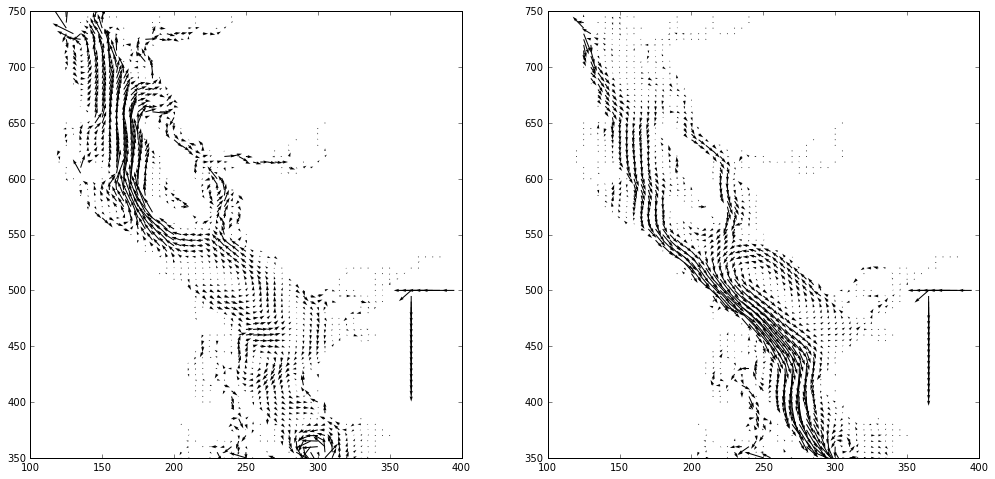

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax[0].quiver(gridX_sub_10, gridY_sub_10, PCAdata['u10'][wind_index > 5, :].mean(axis=0),
                                       PCAdata['v10'][wind_index > 5, :].mean(axis=0))
ax[1].quiver(gridX_sub_10, gridY_sub_10, PCAdata['u10'][wind_index < -5, :].mean(axis=0),
                                       PCAdata['v10'][wind_index < -5, :].mean(axis=0))

### Complex Principal Component Analysis

####Complex Principal Component Analysis via SVD
Rattan and Hsieh 2005, *Neural Networks*

Let $\mathbf{Z}$ be a complex $m \times n$ ($m \le n$) matrix of rank $r$ ($r \le m$)

$$\mathbf{Z} = \mathbf{X} + i\mathbf{Y}$$

where $\mathbf{X}$ and $\mathbf{Y}$ are the real-valued respective u and v velocity fields.

Singular value decomposition (SVD) produces the relation

$$\mathbf{Z} = \mathbf{U}\mathbf{\Lambda}_{r}\mathbf{V}^\mathrm{H}$$

where the columns of $\mathbf{U}$ $(m \times r)$ are eigenvectors of $\mathbf{Z}\mathbf{Z}^\mathrm{H}$ (or scatter matrix)

the columns of $\mathbf{V}$ $(n \times r)$ are eigenvectors of $\mathbf{Z}^\mathrm{H}\mathbf{Z}$

and the main diagonal of $\mathbf{\Lambda}_{r}$ $(r \times r)$ contains the eigenvalues of both $\mathbf{Z}\mathbf{Z}^\mathrm{H}$ and $\mathbf{Z}^\mathrm{H}\mathbf{Z}$.

Thus for our purposes:

the $j$th column of $\mathbf{U}$ is our $j$th spatial pattern, loading, or EOF

the $j$th row of $\mathbf{\Lambda}_{r}\mathbf{V}^\mathrm{H}$ is our PC score or index for the $j$th mode

and the variance fraction explained by the $j$th mode is given by

$$\frac{\lambda_{j}^{2}}{\sum_{j=1}^{r}\lambda_{j}^{2}}$$

Since $\mathbf{\Lambda}_{r}\mathbf{V}^\mathrm{H}$ is complex, we can interpret the PC score as an amplitude and phase of variability.

We can obtain a $j$th mode prediction for $\mathbf{Z}$ $(\mathbf{Z}_{pred})$ using the SVD relation

$$\mathbf{Z}_{pred} = \sum_{j=1}^{r}\mathbf{u}_{j}\lambda_{j}\mathbf{v}_{j}^\mathrm{H}$$

####Varimax Rotation

$$\mathbf{Z} = \mathbf{U}\mathbf{R}\mathbf{R}^{-1}\mathbf{A}^\mathrm{T} = \tilde{\mathbf{E}}\tilde{\mathbf{A}}^\mathrm{T}$$

$$\tilde{\mathbf{A}} = \mathbf{A}\mathbf{R}$$

In [46]:
# Find the currents anomaly
PCAdata['u0_filter_anomaly'] = PCAdata['u0_filter'] - PCAdata['u0_filter'].mean(axis=0)[np.newaxis, :]
PCAdata['v0_filter_anomaly'] = PCAdata['v0_filter'] - PCAdata['v0_filter'].mean(axis=0)[np.newaxis, :]

# Make the complex matrix
Z = PCAdata['u0_filter_anomaly'] + 1j * PCAdata['v0_filter_anomaly']

Complex PCA

In [47]:
# Singular value decomposition
U, L, V_H = np.linalg.svd(Z.T, full_matrices=False)

# Extract PCs
PC = np.angle(np.diag(L).dot(V_H), deg=True)
PC[PC < 0] = PC[PC < 0] + 360
PC[PC > 360] = PC[PC > 360] - 360

# Extract explained variance
PercentVar = L**2/(L**2).sum()

Plot Modes

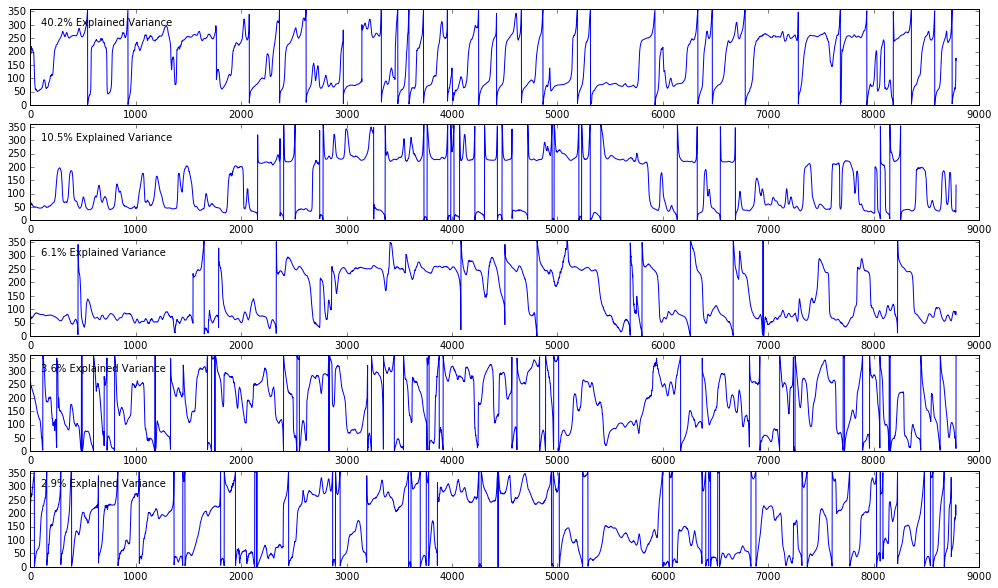

In [48]:
# Plot Modes
fig, axs = plt.subplots(5, 1, figsize=(17, 10))
for index, ax in enumerate(axs):
    ax.plot(PC[index, :])
    ax.set_ylim([0, 360])
    ax.text(100, 300, '{:.1f}% Explained Variance'.format(PercentVar[index]*100))

Extract Mode 1

In [52]:
# Create Mode 1 fields
Z_pred = U[:, 0, np.newaxis].dot(L[0] * V_H[np.newaxis, 0, :]).T

Mode 1 PC Scores and predicted fields

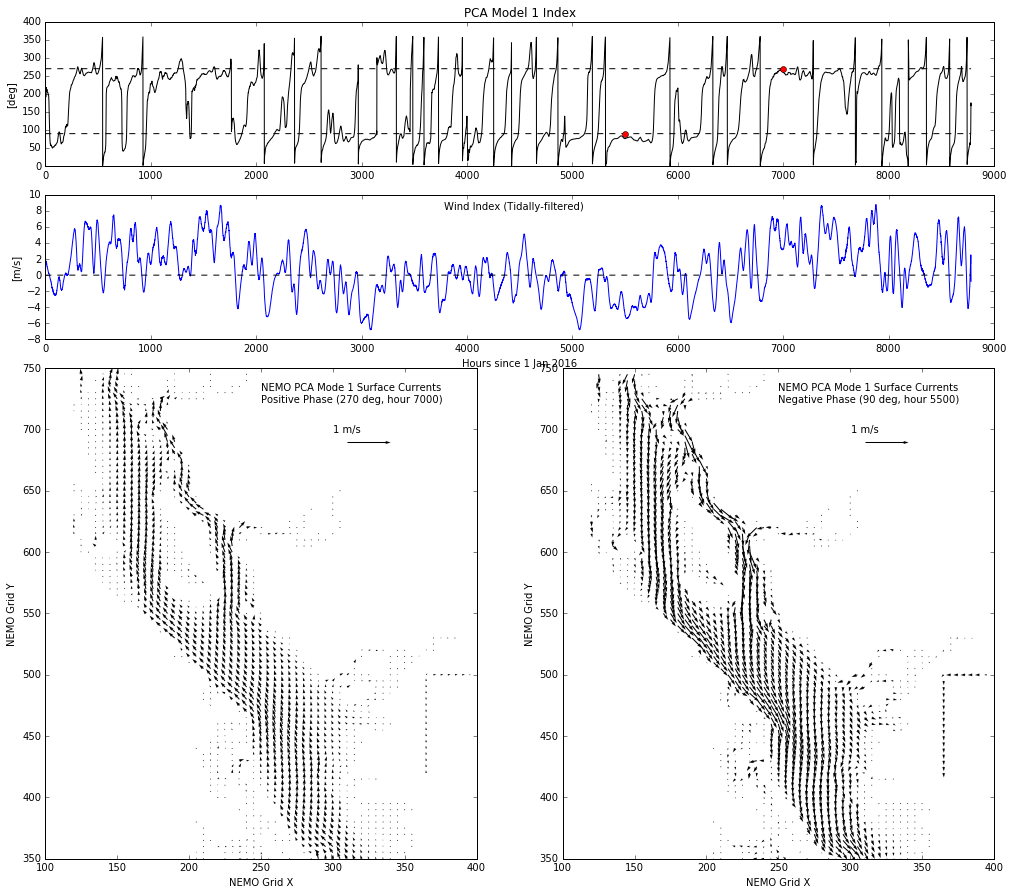

In [82]:
# Mode 2 PC Scores
ax = [0, 0, 0, 0]

fig = plt.figure(figsize=(17, 15))

gs = gridspec.GridSpec(5, 2)

ax[0] = plt.subplot(gs[0, :])
ax[1] = plt.subplot(gs[1, :])
ax[2] = plt.subplot(gs[2:, 0])
ax[3] = plt.subplot(gs[2:, 1])

ax[0].plot(PC[0, :], 'k-')
ax[0].plot(np.ones(PC[0, :].shape)*90, 'k--')
ax[0].plot(np.ones(PC[0, :].shape)*270, 'k--')
ax[0].plot(5500, 90, 'ro')
ax[0].plot(7000, 270, 'ro')
ax[0].set_title('PCA Model 1 Index')
ax[0].set_ylabel('[deg]')

ax[1].plot(wind_index_filter)
ax[1].plot(np.zeros(wind_index_filter.shape), 'k--')
ax[1].set_ylabel('[m/s]')
ax[1].text(.42, .9, 'Wind Index (Tidally-filtered)', transform=ax[1].transAxes)
ax[1].set_xlabel('Hours since 1 Jan 2016')

Q1 = ax[2].quiver(gridX_sub_0, gridY_sub_0, Z_pred.real[7000], Z_pred.imag[7000], scale=10)
ax[2].text(.5, .93, 'NEMO PCA Mode 1 Surface Currents\nPositive Phase (270 deg, hour 7000)', transform=ax[2].transAxes)
plt.quiverkey(Q1, 0.7, 0.85, 1, '1 m/s')
ax[2].set_xlabel('NEMO Grid X')
ax[2].set_ylabel('NEMO Grid Y')

Q2 = ax[3].quiver(gridX_sub_0, gridY_sub_0, Z_pred.real[5500], Z_pred.imag[5500], scale=10)
ax[3].text(.5, .93, 'NEMO PCA Mode 1 Surface Currents\nNegative Phase (90 deg, hour 5500)', transform=ax[3].transAxes)
plt.quiverkey(Q2, 0.7, 0.85, 1, '1 m/s')
ax[3].set_xlabel('NEMO Grid X')
ax[3].set_ylabel('NEMO Grid Y')

fig.savefig('/home/bmoorema/Desktop/Papers/ProposalDocs/PCA.eps', dpi=300, bbox_inches='tight')